In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
import glob
import imageio
# Import everything needed to edit/save/watch video clips
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline




/home/carnd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
# load pickled distortion matrix
with open('camera_cal/output/cal_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [4]:
# Read in an image
#img = cv2.imread('test_image.png')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

In [5]:
# Convert to grayscale
def to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

In [6]:
def abs_sobel_thresh(img, orient='x', thresh_min=85, thresh_max=195):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sobel_binary

In [7]:
def rgb_thresh(img):
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    return r_g_condition

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met # no scaling
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

In [9]:
def hls_select(img, s_thresh=(110, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Apply a threshold to the S channel
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Return a binary image of threshold result
    #binary_hls[((s_binary == 1))] =1

    return s_binary

In [10]:
def mask_ROI(image):
    # apply the region of interest mask
    height,width = image.shape
    #print(image.shape,height,width)
    mask = np.zeros_like(image)
    #region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    region_of_interest_vertices = np.array( [[(width/7, height),(0.4*width, 0.6*height),(0.6*width, 0.6*height),(0.92*width, height)]], dtype=np.int32 )
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    plt.imshow(mask)
    ROI_thresholded = cv2.bitwise_and(image, mask)
    return ROI_thresholded

In [11]:
def perspactive_transform(img, warp=True):
    offset = [150,0] # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # define 4 corners of ROI
    #corners = np.float32([[190,720],[589,470],[698,470],[1145,720]])
    corners = np.float32([[200,720],[570,470],[722,470],[1130,720]])
    # define 4 
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[320,720], [320,1], [920, 1], [920, 720]])    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M

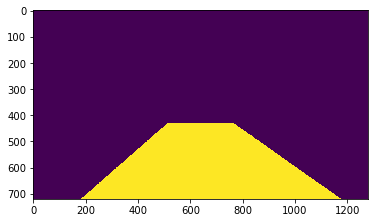

In [12]:
def get_thresholded_image(img):
    #img=mpimg.imread('./test_images/straight_lines1.jpg')
    
    undistorted = cal_undistort(img)
    img_size = (img.shape[1], img.shape[0])
    
    # Apply each of the thresholding functions
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    gray = to_grayscale(img)
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=255)
    #grady = abs_sobel_thresh(gray, orient='y', thresh_min=5, thresh_max=95)
    rgb_binary = rgb_thresh(img)
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    binary_hls = hls_select(img, s_thresh=(150, 255))
    
    channels = 255*np.dstack(( np.zeros_like(gradx), gradx, binary_hls)).astype('uint8')  
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (binary_hls == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (dir_binary == 1)) | ((binary_hls == 1) & (rgb_binary == 1))] = 1
    #combined[(binary_hls == 1) & (grady == 1) | (gradx == 1)] = 1
    final_combined = 255*np.dstack((combined,combined,combined)).astype('uint8')
    
    image_ROI = mask_ROI(combined)
    #image_ROI = to_grayscale(image_ROI)
    
    
    warped, M = perspactive_transform(image_ROI)
    
    return warped,image_ROI,final_combined,gray,channels,binary_hls,dir_binary,rgb_binary,gradx

img=plt.imread('./test_images/test5.jpg')
warped,image_ROI,final_combined,gray,channels,binary_hls,dir_binary,rgb_binary,gradx = get_thresholded_image(img)
#plt.imshow(warped)

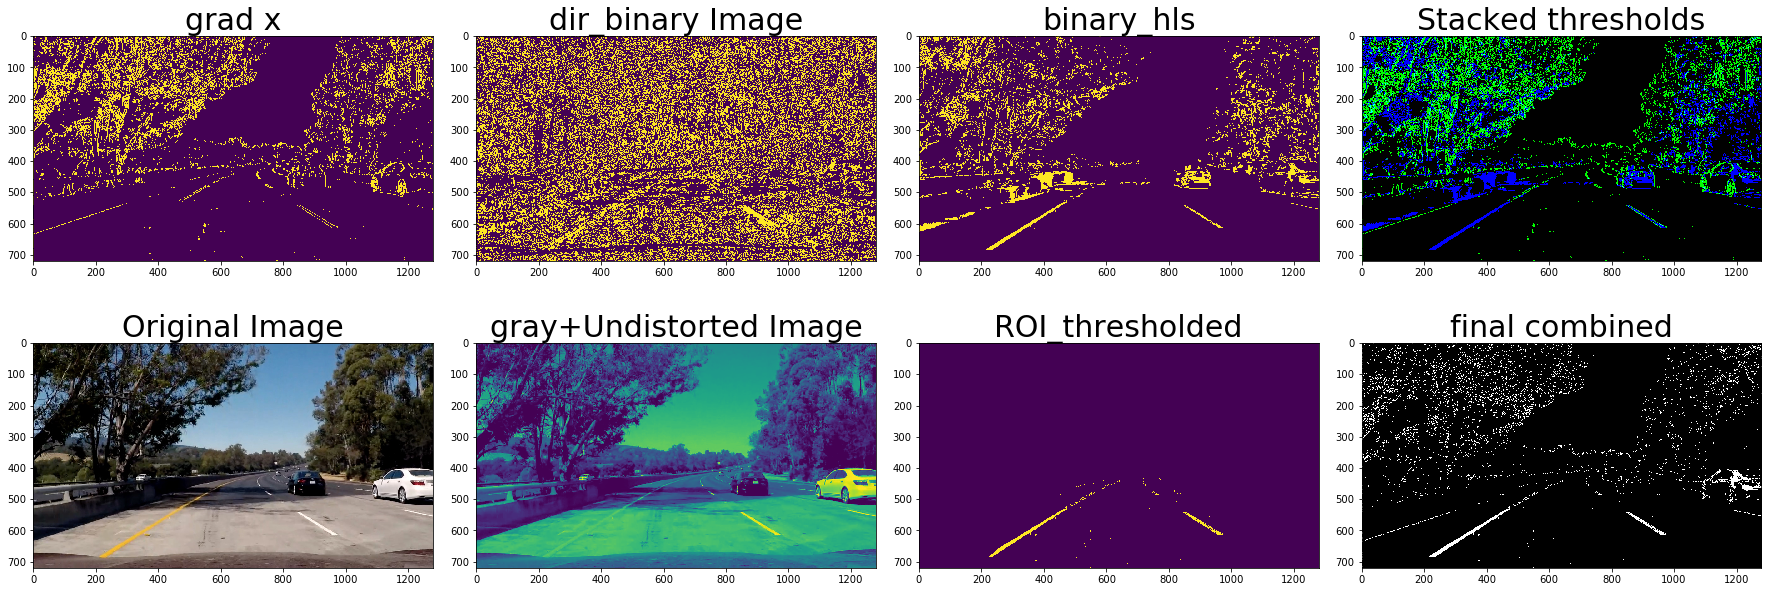

In [13]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx)
ax1.set_title('grad x', fontsize=30)
ax2.imshow(dir_binary)
ax2.set_title('dir_binary Image', fontsize=30)
ax3.imshow(binary_hls)
ax3.set_title('binary_hls', fontsize=30)
ax4.imshow(channels)
ax4.set_title('Stacked thresholds', fontsize=30)
ax5.imshow(img)
ax5.set_title('Original Image', fontsize=30)
ax6.imshow(gray)
ax6.set_title('gray+Undistorted Image', fontsize=30)
ax7.imshow(image_ROI)
ax7.set_title('ROI_thresholded', fontsize=30)
ax8.imshow(final_combined)
ax8.set_title('final combined', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

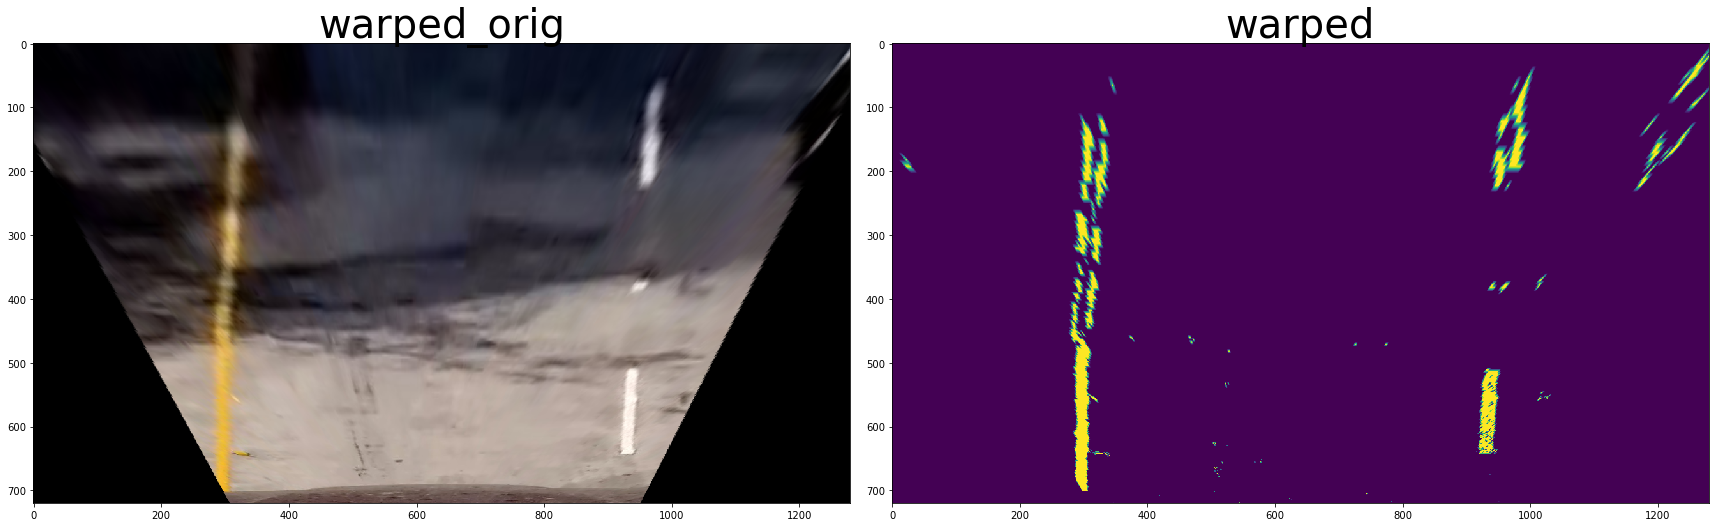

In [14]:
# apply the region of interest mask
img_size = (img.shape[1], img.shape[0])
height,width,_ = img.shape
mask = np.zeros_like(img)
#region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
region_of_interest_vertices = np.array( [[(width/7, height),(0.4*width, 0.6*height),(0.6*width, 0.6*height),(0.92*width, height)]], dtype=np.int32 )
cv2.fillPoly(mask, [region_of_interest_vertices], (255,255,255))
orig_ROI = cv2.bitwise_and(img, mask)
warped_orig, M2 = perspactive_transform(orig_ROI)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_orig)
ax1.set_title('warped_orig', fontsize=40)

ax2.imshow(warped)
ax2.set_title('warped', fontsize=40)

# Histogram
The peaks int the histogram tell us about the likely position of the lanes in the image.

291 933


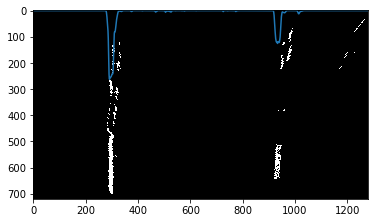

In [15]:
def histogram(warped):
    binary_warped = np.copy(warped)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255   # if using l_channel to remove colors
    out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')  # if using CV2.___2gray
    plt.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    print(leftx_base, rightx_base)
    plt.plot(histogram)
    
    return leftx_base,rightx_base,midpoint,out_img

leftx_base,rightx_base,midpoint,out_img = histogram(warped)

291 933

leftx and lefty: [286 287 288 289 290 291 292 293 294 295] [640 640 640 640 640 640 640 640 640 640]

 [29527 29528 29529 29530 29531 29532 29533 29534 29535 29536] [286 287 288 289 290 291 292 293 294 295]

 [29527 29528 29529 29530 29531 29532 29533 29534 29535 29536] [640 640 640 640 640 640 640 640 640 640]
720 [ 337.52971176  337.39282507  337.25617455  337.11976018  336.98358198
  336.84763994  336.71193405  336.57646433  336.44123077  336.30623337]


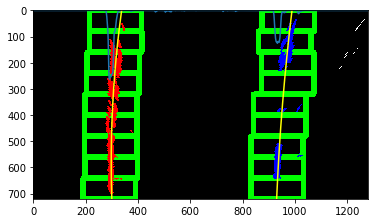

In [16]:
def find_lines(warped):
    binary_warped = np.copy(warped)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_base,rightx_base,midpoint,out_img = histogram(warped)
    out_img__current = np.copy(out_img)
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 200
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 20) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 20) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        #print(len(good_left_inds),good_left_inds.shape,good_left_inds[:10])
        #print(len(good_right_inds),good_right_inds.shape,good_right_inds[:10],"\n")
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    #print(len(left_lane_inds[0]),len(left_lane_inds[8]))  # 0,1,2..8 windows
    # Concatenate the arrays of indices (pixels inside windows)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #print(len(left_lane_inds))
    
    # Extract left and right line pixel positions within those windows
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    print("\nleftx and lefty:", leftx[:10], lefty[:10])  #random 10 pixels --testing purpose #comment out
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    print("\n", left_lane_inds[:10], nonzerox[left_lane_inds[:10]])  #X pos random 10 pixels --testing purpose #comment out
    print("\n", left_lane_inds[:10], nonzeroy[left_lane_inds[:10]])  #Y pos random 10 pixels --testing purpose #comment out
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    print(len(left_fitx),left_fitx[:10])   #random 10 pixels --testing purpose #comment out
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin
    
left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin = find_lines(warped)

In [17]:
def find_nxtLines(left_fit,right_fit,warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    binary_warped = np.copy(warped)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    print(len(left_lane_inds),left_lane_inds[:10])   #random 10 pixels --testing purpose #comment out
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin

left_fit,right_fit,left_fitx,right_fitx,warped,left_lane_inds,right_lane_inds,margin = find_nxtLines(left_fit,right_fit,warped)

30996 [ True  True  True  True  True  True  True False False False]


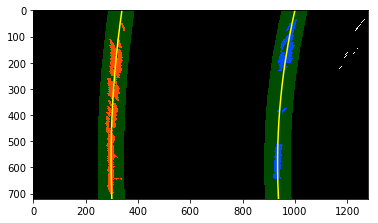

In [18]:
def draw_lane(left_fit,right_fit,warped,left_lane_inds,right_lane_inds,margin):
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    binary_warped = np.copy(warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    
    out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')  # if using CV2.___2gray
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

draw_lane(left_fit,right_fit,warped,left_lane_inds,right_lane_inds,margin)

### Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.
The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [19]:
# Define y-value where we want radius of curvature 
# I'll choose the maximum y-value, corresponding to the bottom of the image
binary_warped = np.copy(warped)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)   #in pixels

3954.37868704 2591.84669007


In [20]:
def radius_offset(left_fitx,right_fitx):
    #we actually need to repeat this calculation after converting our x and y values to real world space (in meters)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm') # in meters
    
    average_curverad = (left_curverad + right_curverad)/2
    curvature_string = "Radius of curvature averaged of left and right curve: %.2f m" % average_curverad
    #print(curvature_string)
    
    # Offset
    #The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.
    lane_center = (left_fitx[719] + right_fitx[719])/2
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    #print("offset of cener camera from center of lane: ", center_offset_meters)
    
    return average_curverad, center_offset_meters

average_curverad, center_offset_meters = radius_offset(left_fitx,right_fitx)

1440 
 [[ 338.62888627    0.        ]
 [ 338.48451522    1.        ]
 [ 338.34039759    2.        ]
 [ 338.19653338    3.        ]
 [ 338.0529226     4.        ]
 [ 337.90956524    5.        ]
 [ 337.76646131    6.        ]
 [ 337.6236108     7.        ]
 [ 337.48101371    8.        ]
 [ 337.33867005    9.        ]]


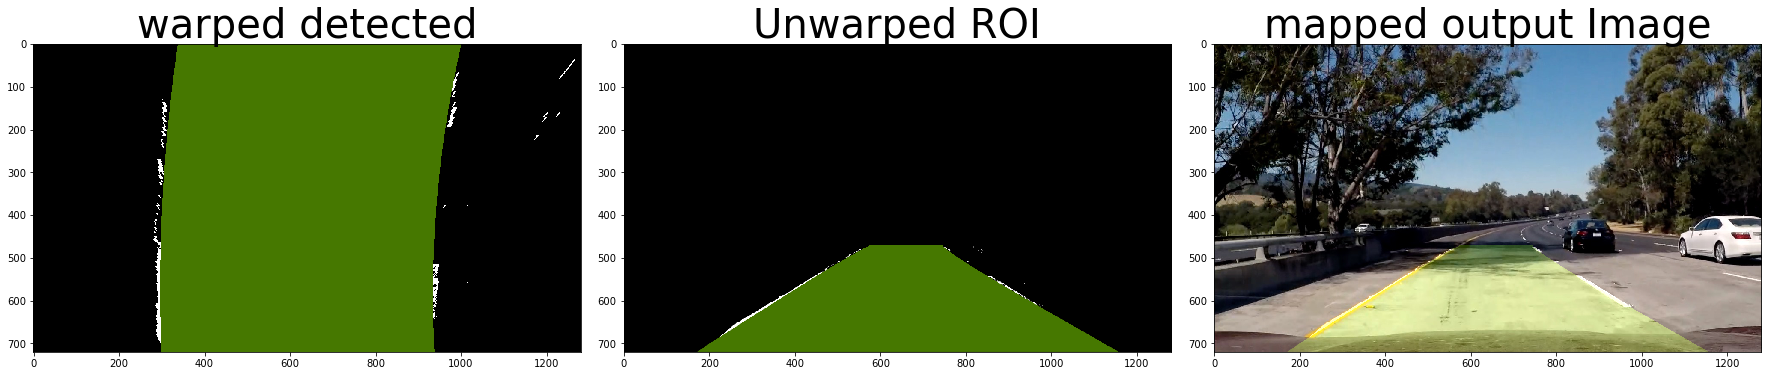

In [21]:
#out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')  # if using CV2.___2gray
#y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))

line_points = np.vstack((left_line_window, right_line_window))
print(len(line_points),'\n',line_points[:10])

cv2.fillPoly(out_img, np.int_([line_points]), [70,120, 0])
#plt.imshow(out_img)

image_unwrpd, M_inv = perspactive_transform(out_img, warp=False)

result = cv2.addWeighted(img, 1, image_unwrpd, 0.5, 0)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img, cmap='gray')
ax1.set_title('warped detected', fontsize=40)
ax2.imshow(image_unwrpd, cmap='gray')
ax2.set_title('Unwarped ROI', fontsize=40)   #FYI only, not used anywhere in this secftion
ax3.imshow(result)
ax3.set_title('mapped output Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [22]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    image_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    # get thresholded image
    thresholded = get_thresholded_image(img)
    
    # perform a perspective transform
    warped, M = perspactive_transform(image_ROI)
    #warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    #out_img = np.dstack((warped, warped, warped))*255
    out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8')  # if using CV2.___2gray
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    average_curverad, center_offset_meters = radius_offset(left_x_predictions,right_x_predictions)
    curvature_string = "Radius of curvature: %.2f m" % average_curverad
    # print the offset from the center
    offset_string = "Center offset: %.2f m" % center_offset_meters
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    #unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
    image_unwrpd, M_inv = perspactive_transform(out_img, warp=False)
    
    #print(img.shape, image_unwrpd.shape)

    result = cv2.addWeighted(img, 1, image_unwrpd, 0.5, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

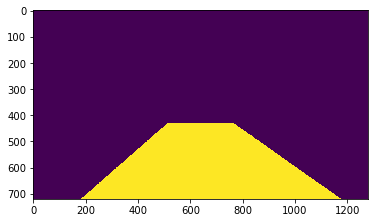

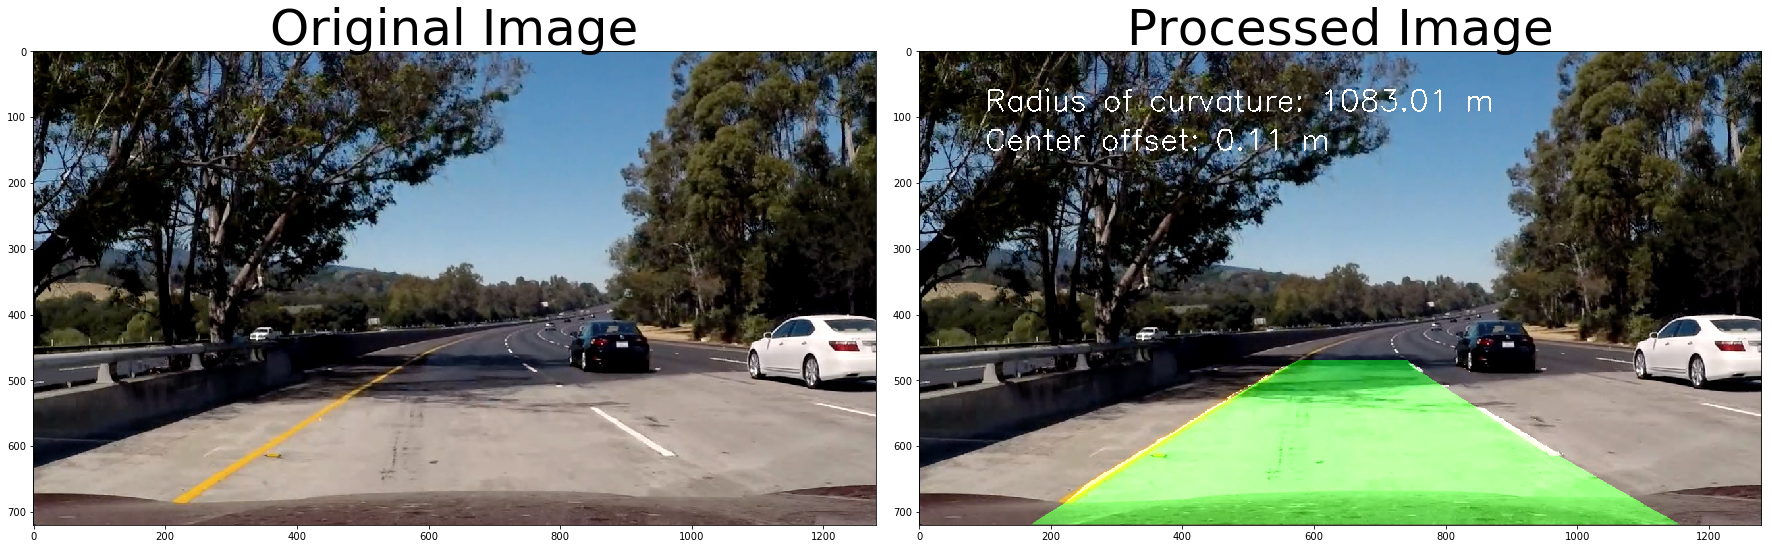

In [23]:
#img = mpimg.imread('test_images/test2.jpg')
img=plt.imread('./test_images/test5.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Process Video

In [24]:
from moviepy.editor import VideoFileClip
#from signal import signal, SIGPIPE, SIG_DFL
#signal(SIGPIPE,SIG_DFL) 

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:25<00:00,  3.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 19min 53s, sys: 34 s, total: 20min 27s
Wall time: 6min 26s


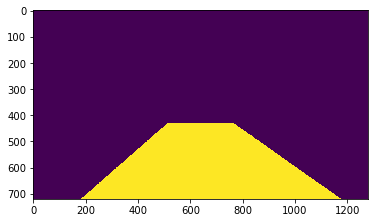

In [25]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

video_in = VideoFileClip("project_video.mp4")
video_out = 'project_video_output.mp4'
out_clip = video_in.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_out, audio=False)